In [1]:
from ddks.data import *
from ddks.data.openimages_dataset import LS
from ddks import methods
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import tqdm
import torch
import numpy as np
import pandas as pd
import pickle
import time
import os
import matplotlib.pyplot as plt

import matplotlib as mpl
plt.style.use('ah')
plt.show()
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', ['348ABD','E24A33', '988ED5', '777777', 'FBC15E', '8EBA42', 'FFB5B8'])



Bad key "mathtext.fallback" on line 27 in
/home/hage581/.config/matplotlib/stylelib/belle2_serif.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "mathtext.fallback" on line 36 in
/home/hage581/.config/matplotlib/stylelib/belle2.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
methods_list = [methods.ddks_method,  methods.vdks_method, methods.rdks_method, methods.onedks_method,
                methods.hotelling_method, methods.kldiv_method]
datasets = [MM]#, MM]
sample_sizes = np.geomspace(2, 20000, 10).astype(int)
sample_sizes = np.concatenate(sample_sizes, [50_000, 100_000]).flatten().astype(int)
trials = 25

def time_method(_method, Dataset, dimension, parameter, sample_size=100, permutations=100, gpu=False):
    if Dataset.name == 'GVM':
        kwargs = dict(mean_p=0.5+parameter, mean_t=0.5)
    elif Dataset.name == 'GVS':
        kwargs = dict(std_p=0.5+parameter, std_t=0.5)
    elif Dataset.name == 'Skew':
        kwargs = dict(lambda_p=0.5+parameter, lambda_t=0.5)
    elif Dataset.name == 'MM':
        kwargs = dict(noise_fraction=parameter)
        
    _dataset = Dataset(dimension=dimension, sample_size=sample_size, **kwargs)
    p, t = next(_dataset)
    try:
        if gpu:
            p = p.cuda()
            t = t.cuda()
        start = time.time()
        d = _method.score_function(p, t)
        end = time.time()
        return end - start
    except:
        return np.nan

if os.path.isfile('times_gpu.pkl'):
    times_gpu = pickle.load(open('times_gpu.pkl', 'rb'))
else:
    times_gpu = np.empty((len(methods_list), len(datasets), len(sample_sizes), trials))
for i, method in enumerate(methods_list):
    print(method.name)
    for j, dataset in enumerate(datasets):
        for k, sample_size in enumerate(tqdm.tqdm(sample_sizes)):
            for l in range(trials):
                if 'rdKS' not in method.name:
                    continue
                times_gpu[i, j, k, l] = time_method(method, dataset, dimension=3, parameter=0.0, sample_size=sample_size)

pickle.dump(times_gpu, open('times_gpu.pkl', 'wb'))

  0%|          | 0/10 [00:00<?, ?it/s]

ddKS
vdKS
rdKS


100%|██████████| 10/10 [00:00<00:00, 117159.33it/s]

OnedKS
HotellingT2
KLDiv


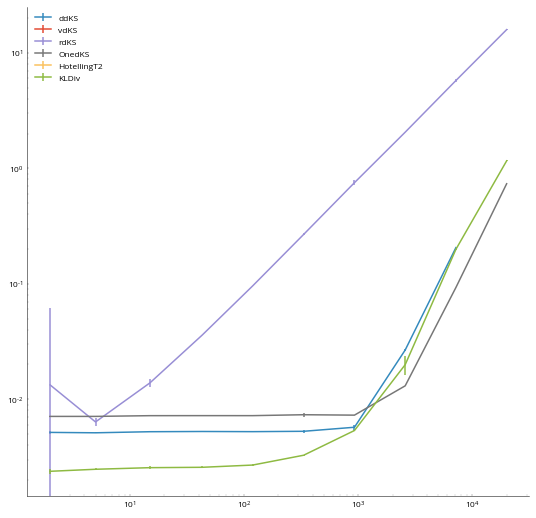

In [3]:
plt.figure(figsize=(9,9))

for i, method in enumerate(methods_list):
    for j, dataset in enumerate(datasets):
        mean_times = np.mean(times_gpu[i, j, ...], axis=1)
        std_times = np.std(times_gpu[i, j, ...], axis=1)
        plt.errorbar(sample_sizes, mean_times, yerr=std_times, label=method.name)
plt.loglog()
plt.legend()
#plt.show()

In [4]:
def time_method(_method, Dataset, dimension, parameter, sample_size=100, permutations=100):
    if Dataset.name == 'GVM':
        kwargs = dict(mean_p=0.5+parameter, mean_t=0.5)
    elif Dataset.name == 'GVS':
        kwargs = dict(std_p=0.5+parameter, std_t=0.5)
    elif Dataset.name == 'Skew':
        kwargs = dict(lambda_p=0.5+parameter, lambda_t=0.5)
    elif Dataset.name == 'MM':
        kwargs = dict(noise_fraction=parameter)
        
    _dataset = Dataset(dimension=dimension, sample_size=sample_size, **kwargs)
    p, t = next(_dataset)
    start = time.time()
    d = _method.score_function(p, t)
    end = time.time()
    diff = end - start
    return diff

if os.path.isfile('times.pkl'):
    times = pickle.load(open('times.pkl', 'rb'))
else:
    times = np.empty((len(methods_list), len(datasets), len(sample_sizes), trials))
for i, method in enumerate(methods_list):
    print(method.name)
    for j, dataset in enumerate(datasets):
        for k, sample_size in enumerate(tqdm.tqdm(sample_sizes)):
            for l in range(trials):
                if 'rdKS' not in method.name:
                    continue
                times[i, j, k, l] = time_method(method, dataset, dimension=3, parameter=0.0, sample_size=sample_size)

pickle.dump(times, open('times.pkl', 'wb'))

  0%|          | 0/10 [00:00<?, ?it/s]

ddKS
vdKS
rdKS


100%|██████████| 10/10 [00:00<00:00, 62695.13it/s]

OnedKS
HotellingT2
KLDiv


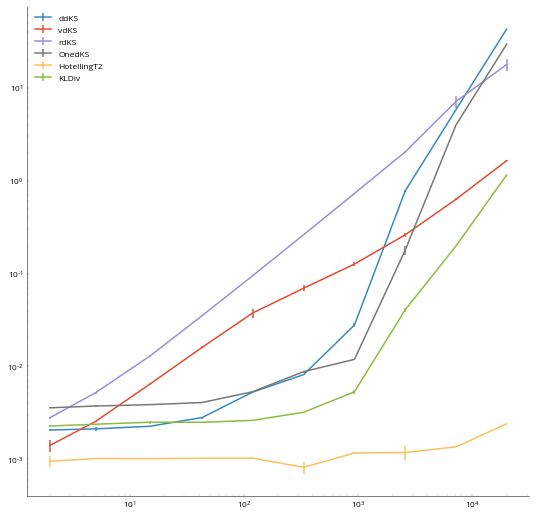

In [5]:
plt.figure(figsize=(9,9))

for i, method in enumerate(methods_list):
    for j, dataset in enumerate(datasets):
        mean_times = np.mean(times[i, j, ...], axis=1)
        std_times = np.std(times[i, j, ...], axis=1)
        plt.errorbar(sample_sizes, mean_times, yerr=std_times, label=method.name)
plt.loglog()
plt.legend()
#plt.show()

In [6]:
import resource

resource.setrlimit(resource.RLIMIT_NPROC, (1, 1))
torch.set_num_threads(1)

#sample_sizes = np.geomspace(2, 10, 2).astype(int)

if os.path.isfile('times_single.pkl'):
    times_single = pickle.load(open('times_single.pkl', 'rb'))
else:
    times_single = np.empty((len(methods_list), len(datasets), len(sample_sizes), trials))
for i, method in enumerate(methods_list):
    print(method.name)
    for j, dataset in enumerate(datasets):
        for k, sample_size in enumerate(tqdm.tqdm(sample_sizes)):
            for l in range(trials):
                if 'rdKS' not in method.name:
                    continue
                if sample_size == sample_sizes[-2] or sample_size == sample_sizes[-1]:
                    times_single[i, j, k, l] = np.nan
                else:
                    diff = time_method(method, dataset, dimension=3, parameter=0.0, sample_size=sample_size)
                    times_single[i, j, k, l] = diff

pickle.dump(times_single, open('times_single.pkl', 'wb'))

#times_single = pickle.load(open('times_single.pkl', 'rb'))
print(times_single)

 10%|█         | 1/10 [00:00<00:01,  8.87it/s]

ddKS
vdKS
rdKS


100%|██████████| 10/10 [00:00<00:00, 47608.44it/s]

OnedKS
HotellingT2
KLDiv
[[[[2.95162201e-03 2.10785866e-03 2.12001801e-03 ... 2.09474564e-03
    2.11691856e-03 2.09951401e-03]
   [2.66551971e-03 2.10666656e-03 2.08497047e-03 ... 2.09116936e-03
    2.11334229e-03 2.64930725e-03]
   [2.23565102e-03 2.21800804e-03 2.26759911e-03 ... 2.25305557e-03
    2.30932236e-03 2.34246254e-03]
   ...
   [5.87387967e+00 5.54217005e+00 5.74181604e+00 ... 5.08090138e+00
    4.68262100e+00 4.64469886e+00]
   [           nan            nan            nan ...            nan
               nan            nan]
   [           nan            nan            nan ...            nan
               nan            nan]]]


 [[[1.80673599e-03 1.31559372e-03 1.30963326e-03 ... 1.29508972e-03
    1.29032135e-03 1.29008293e-03]
   [2.46906281e-03 2.58159637e-03 2.73036957e-03 ... 2.59709358e-03
    2.31838226e-03 2.45475769e-03]
   [6.31332397e-03 6.29425049e-03 6.17694855e-03 ... 6.41822815e-03
    6.86669350e-03 6.17885590e-03]
   ...
   [2.65359402e-01 2.68634796e

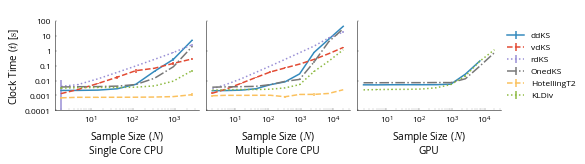

In [11]:
fig = plt.figure(figsize=(8, 8/3/1.618))
lss = dict(ddKS='-', vdKS='--', rdKS=':', OnedKS='-.', HotellingT2='--', KLDiv=':')
#times_single = np.nan * np.ones_like(times)
max_max = np.nanmax([np.nanmax(times_single), np.nanmax(times), np.nanmax(times_gpu)])
min_min = np.nanmin([np.nanmin(times_single), np.nanmin(times), np.nanmin(times_gpu)])
plt.subplot(131)
ax1 = plt.gca()
for i, method in enumerate(methods_list):
    for j, dataset in enumerate(datasets):
        mean_times = np.mean(times_single[i, j, ...], axis=1)
        std_times = np.std(times_single[i, j, ...], axis=1)
        plt.errorbar(sample_sizes, mean_times, yerr=std_times, ls=lss[method.name], label=method.name)
plt.loglog()
plt.ylabel(r'Clock Time ($t$) [$\mathrm{s}$]')
plt.xlabel('Sample Size ($N$)' + "\n" + 'Single Core CPU')
plt.subplot(132)
for i, method in enumerate(methods_list):
    for j, dataset in enumerate(datasets):
        mean_times = np.mean(times[i, j, ...], axis=1)
        std_times = np.std(times[i, j, ...], axis=1)
        plt.errorbar(sample_sizes, mean_times, yerr=std_times, ls=lss[method.name], label=method.name)
plt.loglog()
plt.xlabel('Sample Size ($N$)' + "\n" + 'Multiple Core CPU')
plt.subplot(133)
for i, method in enumerate(methods_list):
    
    for j, dataset in enumerate(datasets):
        mean_times = np.mean(times_gpu[i, j, ...], axis=1)
        std_times = np.std(times_gpu[i, j, ...], axis=1)
        if 'rdKS' in method.name:
            mean_times = len(sample_sizes) * [np.nan]
            std_times = len(sample_sizes) * [np.nan]
        plt.errorbar(sample_sizes, mean_times, yerr=std_times, ls=lss[method.name], label=method.name)
plt.loglog()
plt.xlabel('Sample Size ($N$)' + "\n" + 'GPU')
handles, labels = plt.gca().get_legend_handles_labels()
fig.subplots_adjust(right=0.90, wspace=0.05)
legend_ax = fig.add_axes([0.92, 0.00, 0.10, 1.0])
plt.sca(legend_ax)
plt.axis('off')
legend = plt.legend(handles, labels, loc='center')
yt = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100]
for i in range(3):
    plt.subplot(131 + i)
    plt.loglog()
    plt.ylim(min(yt), max(yt))
    if i > 0:
        plt.setp(plt.gca().get_yticklabels(), visible=False)
plt.subplot(131)
plt.yticks(yt, ['0.0001', '0.001', '0.01', '0.1',  '1',  '10', '100'])
plt.savefig('clock_time.pdf', bbox_inches='tight')
#plt.show()

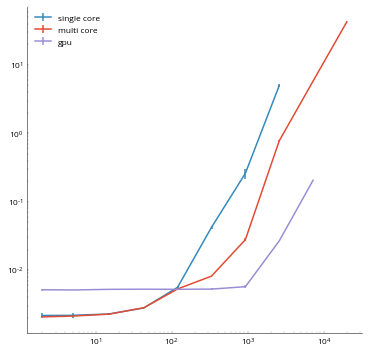

In [8]:
plt.figure(figsize=(6, 6))
for i, method in enumerate(methods_list):
    for j, dataset in enumerate(datasets):
        if 'ddKS' in method.name:
            mean_times = np.mean(times_single[i, j, ...], axis=1)
            std_times = np.std(times_single[i, j, ...], axis=1)
            plt.errorbar(sample_sizes, mean_times, yerr=std_times, label='single core')
for i, method in enumerate(methods_list):
    for j, dataset in enumerate(datasets):
        if 'ddKS' in method.name:
            mean_times = np.mean(times[i, j, ...], axis=1)
            std_times = np.std(times[i, j, ...], axis=1)
            plt.errorbar(sample_sizes, mean_times, yerr=std_times,  label='multi core')
for i, method in enumerate(methods_list):
    for j, dataset in enumerate(datasets):
        if 'ddKS' in method.name:
            mean_times = np.mean(times_gpu[i, j, ...], axis=1)
            std_times = np.std(times_gpu[i, j, ...], axis=1)
            plt.errorbar(sample_sizes, mean_times, yerr=std_times,  label='gpu')
plt.legend()
plt.loglog()
plt.show()